# 1. 정확도(Accuracy)
### 정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
#### 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능 평가는 지양한다.

#### BaseEstimator를 상속받으면 Customized 형태의 Estimator를 개발자가 생성 가능

In [1]:
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    # SEX가 1이면 0, 그렇지 않으면 0
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        
        return pred

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
## Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

## 머신러닝에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

## Label Encoding 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv('C:\machine_learning_guide\DATA/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

In [4]:
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

In [5]:
mypred = myclf.predict(X_test)
print('{0:.4f}'.format(accuracy_score(y_test, mypred)))

0.7877


#### 위 단순한 알고리즘(sex 에 따른 분류)으로 하더라도 78%가 나올 수 있기에 정확도를 사용할 때 매우 신중해야 한다.

#### 아래를 통해 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤에 정확도 지표 적용 시 발생하는 문제를 볼 것이다.

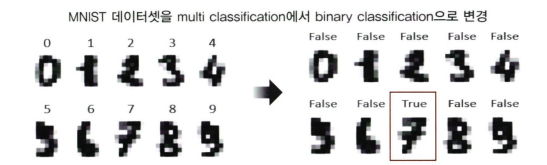

#### 전체 데이터의 10%만 True, 나머지 90%는 False인 불균형한 데이터 세트로 변형했다.

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
        
    # 모두 0 값으로 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
digits = load_digits()

y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [7]:
print('레이블 테스트 세트 크기 : ', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

레이블 테스트 세트 크기 :  (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64


In [8]:
fackclf = MyFakeClassifier()
fackclf.fit(X_train, y_train)
fakepred = fackclf.predict(X_test)

In [9]:
print('정확도 {:.3f}'.format(accuracy_score(y_test, fakepred)))

정확도 0.900


#### 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안된다. -> 여러 가지 분류 지표와 함께 적용

# 2. 오차 행렬
#### 

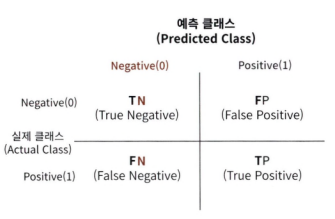

#### 앞 문자 True/False는 예측값과 실제값이 '같은가/틀린가'를 의미하고, 뒤 문자 Negative/Positive는 예측 값이 부정(0)/긍정(1)을 의미한다.

#### TN는 예측값을 Negative 값 0으로 예측했고, 실제 값 역시 Negative 값 0
#### FP는 예측값을 Positive 값 1으로 예측했고, 실제 값은 Negative 값 0
#### FN는 예측값을 Negative 값 0으로 예측했고, 실제 값은 Positive 값 1
#### TP는 예측값을 Positive 값 1으로 예측했고, 실제 값 역시 Positive 값 1

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

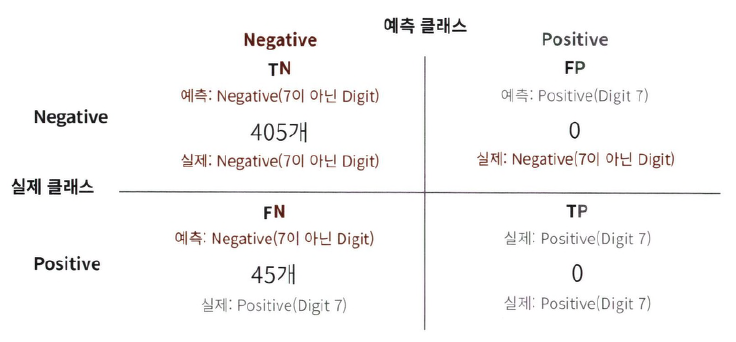

#### 정확도 = 예측 결과와 실제 값이 동일한 건수/전체 데이터 수 = (TN + TP)/(TN + FP + FN + TP)

#### 불균형한 데이터 세트에서 정확도보다 더 선호되는 평가 지표인 정밀도와 재현율

# 3. 정밀도와 재현율
#### 정밀도와 재현율은 Postive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
#### 정밀도 = TP / (FP + TP) : 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
#### 재현율 = TP / (FN + TP) : 실제 값이 Positive인 대상 중에서 예측과 실제 값이 Positive로 일치한 데이터의 비율

#### 재현율이 상대적으로 더 중요한 지표인 경우는 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향을 발생하는 경우 - 암 판단 모델, 금융 사기 적발 모델
#### 정밀도가 상대적으로 더 중요한 지표인 경우는 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 - 스팸 메일 여부 판별 모델

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval1(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd. read_csv('C:\machine_learning_guide\DATA/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1) 
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11) 
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [13]:
pred = lr_clf.predict(X_test)
get_clf_eval1(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


### 정밀도/재현율 트레이드오프
#### 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한 쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽다.

#### 사이킷런은 개별 데이터별로 예측 확률을 반환하는 메서드인 predict_proba() 제공한다.

In [14]:
import numpy as np

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n : ', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print(pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
 :  [[0.44935228 0.55064772]
 [0.86335513 0.13664487]
 [0.86429645 0.13570355]]
[[0.44935228 0.55064772 1.        ]
 [0.86335513 0.13664487 0.        ]
 [0.86429645 0.13570355 0.        ]]


#### predict()는 predict_proba() 메서드가 반환하는 확률 값을 가진 ndarray에서 정해진 임계값을 만족하는 칼럼 위치를 최종 클래스로 결정한다.

In [15]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0, 크면 1 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [17]:
from sklearn.preprocessing import Binarizer

custom_threshold = 0.5

pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval1(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


#### 계산된 결과가 predict()로 계산된 지표 값과 정확히 같다. (predict()가 predict_proba()에 기반함)

#### 임계값에 따른 평가지표 분포를 확인해보자

In [18]:
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값 : ', custom_threshold)
        get_clf_eval1(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값 :  0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197
임계값 :  0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869
임계값 :  0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705
임계값 :  0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377
임계값 :  0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213


#### 임계값 변화에 따른 평가 지표 값들의 분포는 사이킷런에서 precision_recall_curve() API로 제공한다.

In [19]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제 값 데이터 세트와 레이블 값 1일 때의 예측 확률을 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임계값을 15 STEP
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index : ', thr_index)
print('샘플용 10개의 임계값 : ', np.round(thresholds[thr_index], 2))

# 15 STEP 단위로 추출된 정밀도와 재현율 값
print('샘플 임계값별 정밀도 : ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율 : ', np.round(recalls[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index :  [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임계값 :  [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도 :  [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율 :  [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


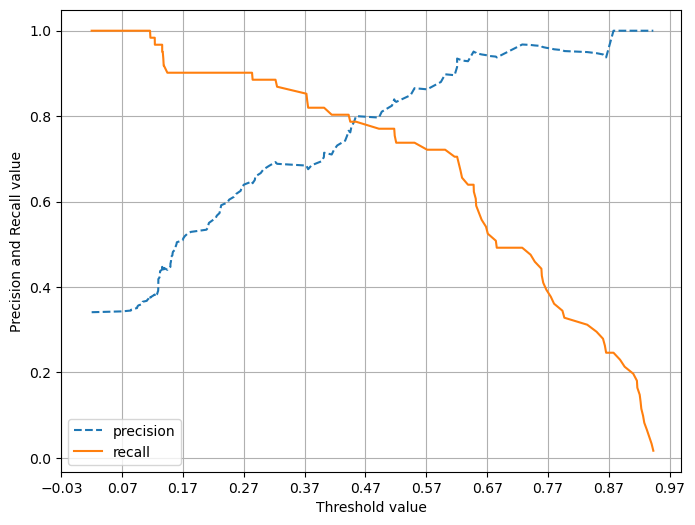

In [20]:
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_testz, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    # X축을 thre아iold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds. shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    # X축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[: ,1])

#### 정밀도 또는 재현율 중 하나만 스코어가 좋다면 성능이 좋지 않은 분류로 간주할 수 있다.
#### 정밀도와 재현율의 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요하다!

# 4. F1 스코어
#### 정밀도와 재현율을 결합한 지표이고, 두 지표가 어느 한쪽으로 치우치치 않은 수치일 때 상대적으로 높은 값을 가진다.
#### F1 = 2 / (( 1 / recall) + ( 1 / precision))  = 2 * (precision * recall) / (precision + recall)

In [21]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어 : {0:.4f}'.format(f1))

F1 스코어 : 0.7966


In [22]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

In [23]:
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값 :  0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197
임계값 :  0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869
임계값 :  0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705
임계값 :  0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377
임계값 :  0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213


#### F1 스코어는 임계값이 0.6일 때 가장 좋은 값을 보여주지만 재현율이 크게 감소하고 있으니 주의해서 사용한다.

# 5. ROC 곡선과 AUC
#### ROC 곡선에 기반한 AUC 스코어는 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표이고, ROC 곡선은 FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선입니다.

#### 민감도(TPR)는 실제 값 Positive(양성)가 정확히 예측돼야 하는 수준을 나타냅니다.
#### 특이성(TNR)은 실제 값 Negative(음성)가 정확히 예측돼야 하는 수준을 나타냅니다.
#### FPR = FP / ( FP + TN ) = 1 - TNR = 1 - 특이성

#### roc_curve() API를 이용해 FPR, TPR, 임계값을 구해 보겠습니다.

In [24]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index : ', thr_index)
print('샘플용 10개의 임계값 : ', np.round(thresholds[thr_index], 2))

# 15 STEP 단위로 추출된 정밀도와 재현율 값
print('샘플 임계값별 FPR : ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR : ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index :  [ 1  6 11 16 21 26 31 36 41 46]
샘플용 10개의 임계값 :  [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임계값별 FPR :  [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임계값별 TPR :  [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


#### 임계값이 1에 가까운 값에서 점점 작아지면서 FPR이 점점 커지고 TPR은 가파르게 커진다.

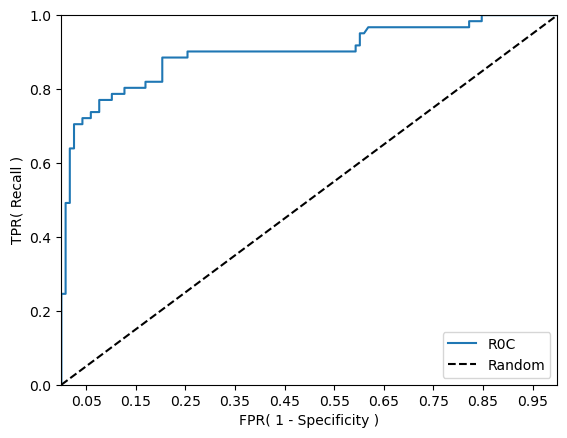

In [25]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림 . 
    plt.plot(fprs, tprs, label='R0C')
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1 ], [0, 1 ], 'k--', label='Random')
    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등 
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR( 1 - Specificity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
roc_curve_plot(y_test, pred_proba[:, 1 ])

#### 분류의 성능 지표로 사용되는 것은 ROC 곡선 면접에 기반한 AUC 값으로 결정합니다. (1에 가까울수록 좋은 수치입니다.)

In [26]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.8987


In [27]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# 6. 피마 인디언 당뇨병 예측
#### 피마 인디언 당뇨병 데이터 세트를 이용해 당뇨병 여부를 판단하는 머신러닝 예측 모델을 수립하고, 지금까지 배운 평가 지표를 적용한다.

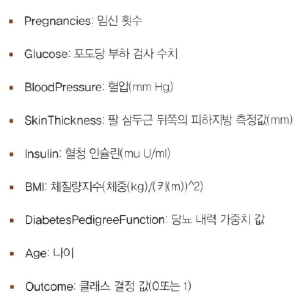

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [29]:
diabetes_data = pd.read_csv('C:\machine_learning_guide\DATA/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [30]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [31]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [32]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

In [33]:
# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926, F1:0.6465, AUC:0.8083


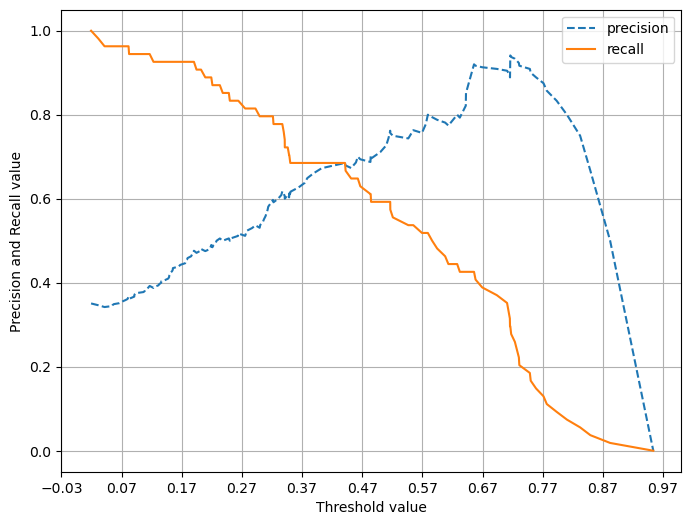

In [34]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

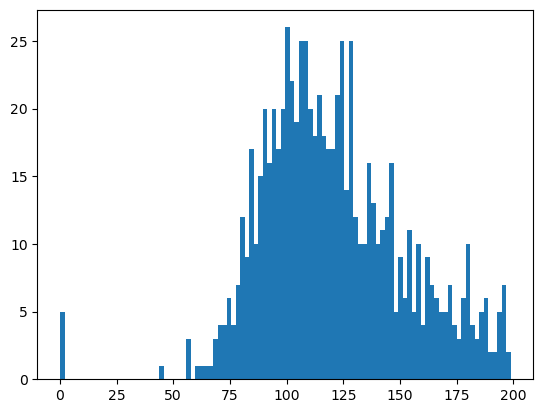

In [35]:
plt.hist(diabetes_data['Glucose'], bins=100)
plt.show()

In [36]:
# 0값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()
# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [37]:
# zero jeatures 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

#### 0 값을 평균값으로 대체하고, 피처 스케일링을 적용해 변환하고 다시 모델 평가 진행 ( 로직스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋다)

In [38]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1:0.6804, AUC:0.8433


In [39]:
thresholds = [0.3, 0,33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값 :  0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963
임계값 :  0
오차 행렬
[[  0 100]
 [  0  54]]
정확도: 0.3506, 정밀도: 0.3506, 재현율: 1.0000
임계값 :  33
오차 행렬
[[100   0]
 [ 54   0]]
정확도: 0.6494, 정밀도: 0.0000, 재현율: 0.0000
임계값 :  0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222
임계값 :  0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037
임계값 :  0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667
임계값 :  0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667
임계값 :  0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481
임계값 :  0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111


C:\Users\junseok\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 임계값 0.48이 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 좋은 임계값이다.

In [40]:
# 임계값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))
get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1:0.6931, AUC:0.8433


# 7. 정리(분류 성능 평가 지표 - 정확도, 오차행렬, 정밀도, 재현율, F1 스코어, ROC-AUC)
### 1) 이진 분류의 레이블 값이 불균형하게 분포될 경우 정확도만으로 예측 성능을 평가하기 힘들다.
### 2) 오차 행렬은 TN, FP, FN, TP로 매핑되는 4분면 행렬을 기반으로 예측 성능을 평가하여 어떤 오류가 발생하는 지 알 수 있다.
### 3) 정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점에 맞춘 평가 지표이다. (임계값 조정으로 각 수치를 높이는 방법)
### 4) F1 스코어는 정밀도와 재현율을 결합한 평가 지표이다. (어느 한 쪽으로 치우치지 않을 때 높은 지표 값)
### 5) ROC-AUC는 일반적으로 이진 분류의 성능 평가를 위해 가장 많이 사용되는 지표이다. ROC 곡선 밑 면적을 구한 것으로서 1에 가까울수록 좋다